# On dry land

This workflow uses the VAT to evaluate the distribution of *Calopteryx splendens* in dependence of the land use classification from the Ökosystematlas and an temporal aggregation of the average air temperature. 

The purpose of this notebook is to demonstrate the capabilities of Geo Engine. Therefore some useful techniques will be shown: 
- Using the GBIF data catalogue
- Point in polygon selection
- Raster vector join of occurrence data with land use classification
- Plotting a class histogram
- Nested workflows

When building your own nested workflow, it is recommended to build it in several steps as shown in this notebook.

Documentation about the operators and how to use them in Python can be found here: [https://docs.geoengine.io/operators/intro.html](https://docs.geoengine.io/operators/intro.html)

## Preparation

In [1]:
#Import packages
import geoengine as ge
import geoengine_openapi_client
from datetime import datetime
from geoengine.types import RasterBandDescriptor
import altair as alt

alt.renderers.enable('default')

RendererRegistry.enable('default')

In [2]:
#Initialize Geo Engine in VAT
ge.initialize("https://vat.gfbio.org/api")

In [3]:
#Get the GBIF DataProvider id (Useful for translating the DataProvider name to its id)
root_collection = ge.layer_collection()
gbif_prov_id = ''
for elem in root_collection.items:
    if elem.name == 'GBIF':
        gbif_prov_id = str(elem.provider_id)
        
gbif_prov_id

'1c01dbb9-e3ab-f9a2-06f5-228ba4b6bf7a'

## Load boundaries of Germany for later GBIF occurrence extraction (optional)

This chapter is not needed and only shows that country boundaries are available

In [4]:
#Create workflow to request germany boundary
workflow_germany = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": "germany",
        }
    }
})

workflow_germany

2429a993-385f-546f-b4f7-97b3ba4a5adb

<Axes: >

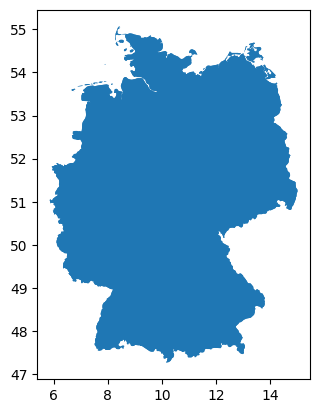

In [5]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_germany.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

## Load Ökosystematlas (detailed) for later raster vector join with occurrence data (optional)

This chapter is not needed and only shows that raster data is also available.

In [6]:
#Create workflow to request the oekosystematlas raster data
workflow_oekosystematlas = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": "oekosystematlas_detail"
        }
    }
})

workflow_oekosystematlas

f447601c-0ba1-57c3-9127-b0622f982231

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


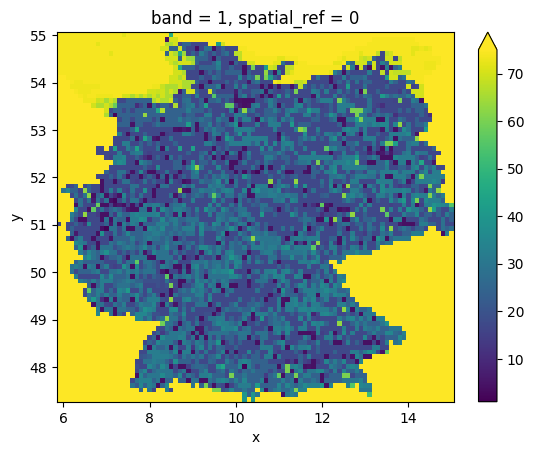

In [7]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a xarray dataarray
data = workflow_oekosystematlas.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmax=75)

## Load Average temperature for later raster vector join with event data (optional)

This chapter is not needed and only shows that raster data is also available.

In [8]:
#Create workflow to request the average temperature raster data
workflow_t_avg = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": "tavg"
        }
    }
})

workflow_t_avg

b92f5a60-aeb1-57ac-a434-7ec7e2869ddb

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


/home/duempelmann/geoengine_env/lib/python3.10/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


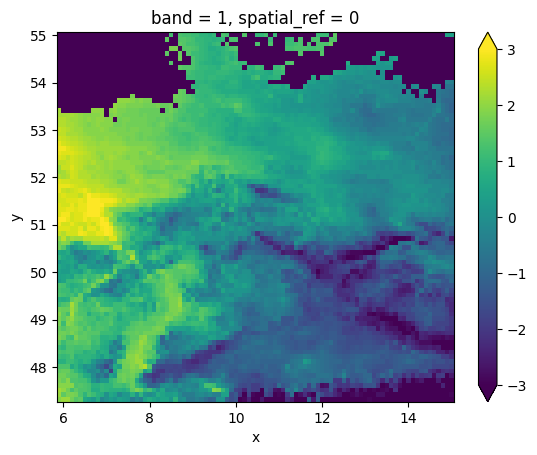

In [9]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a xarray dataarray
data = workflow_t_avg.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmin=-3, vmax=3)

## Processing *Calopteryx splendens*

None of the following steps are necessary in theory, as the entire workflow will be projected in the nested request in the end. However, the steps are intended to show the capabilities of Geo Engine and how to logically build nested workflows.

### Load *Calopteryx splendens* (Optional)

In [10]:
#Create workflow to request Calopteryx splendens occurences
workflow_calopteryx_splendens = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
        }
    }
})

workflow_calopteryx_splendens.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:4326
Columns:
  gbifid:
    Column Type: int
    Measurement: unitless
  scientificname:
    Column Type: text
    Measurement: unitless
  basisofrecord:
    Column Type: text
    Measurement: unitless

<Axes: >

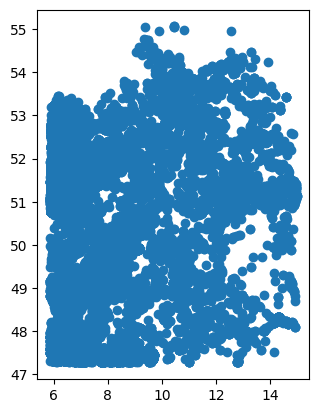

In [11]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_calopteryx_splendens.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

### Point in Polygon *Calopteryx splendens*

In [12]:
#Create workflow to request Calopteryx splendens occurrences filtered by German border
workflow_calopteryx_splendens_cut = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "PointInPolygonFilter",
        "params": {},
        "sources": {
            "points": { #Calopteryx splendens ###############################
                "type": "OgrSource",
                "params": {
                    "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                    "attributeProjection": []
                } 
            }, #####################################################
            "polygons": { #Germany #################################
                "type": "OgrSource",
                "params": {
                    "data": "germany"
                }
            } ######################################################
        } 
    }
})

workflow_calopteryx_splendens_cut

6cf9ef88-8bd3-5904-bc74-f866165b18c3

<Axes: >

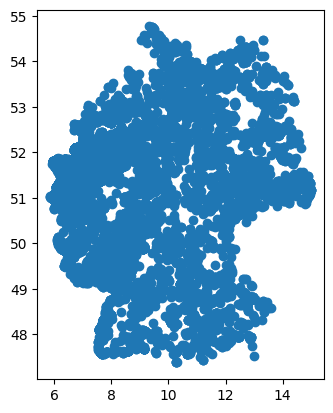

In [13]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data_calopteryx_splendens = workflow_calopteryx_splendens_cut.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data_calopteryx_splendens.plot()

### Nested Point in Polygon and Raster Vector Join *Calopteryx splendens*

In [14]:
#Create a workflow to request Calopteryx splendens occurrences filtered by the German border and linked to the Ökosystematlas data.
workflow_calopteryx_splendens_cut_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
            "names": {
                "type": "names",
                "values": ["Ökosystematlas", "Avg_Temperature"]
            }, 
            "temporalAggregation": "none",
            "featureAggregation": "mean",
        },
        "sources": {
            "vector": { #Calopteryx splendens cut ######################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, ##############################################################
            "rasters": [{ #Ökosystematlas ###################################
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            }, ##############################################################
            { #Average temperature
                "type": "GdalSource",
                "params": {
                    "data": "tavg"
                }
            }] ##############################################################
        },
    }
})

workflow_calopteryx_splendens_cut_join

4f1263cd-489c-5eea-8794-ef794206cabf

In [15]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_calopteryx_splendens_cut_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data

,geometry,Avg_Temperature,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (13.26573 52.74397),0.0,HUMAN_OBSERVATION,2268203074,"Calopteryx splendens Harris, 1780",5.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
1,POINT (8.83490 53.39930),1.2,HUMAN_OBSERVATION,1038563555,"Calopteryx splendens Harris, 1780",8.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
2,POINT (7.54821 51.57662),2.3,HUMAN_OBSERVATION,2844975669,"Calopteryx splendens Harris, 1780",10.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
3,POINT (8.49647 49.97696),1.6,HUMAN_OBSERVATION,3388341563,"Calopteryx splendens Harris, 1780",2.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
4,POINT (6.75000 52.10000),2.2,HUMAN_OBSERVATION,3907238345,"Calopteryx splendens Harris, 1780",6.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...
18019,POINT (8.13673 47.60109),-0.9,HUMAN_OBSERVATION,2994756254,Calopteryx splendens splendens,2.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
18020,POINT (8.80497 47.73006),-0.3,HUMAN_OBSERVATION,2994865479,Calopteryx splendens splendens,2.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
18021,POINT (8.60307 47.64231),0.0,HUMAN_OBSERVATION,2994865740,Calopteryx splendens splendens,255.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
18022,POINT (8.60307 47.64231),0.0,HUMAN_OBSERVATION,2994617569,Calopteryx splendens splendens,255.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00


It can be seen that the Ökosystematlas variable is numerical, while the classes are human-readable encoded in the metadata of the files. This can be adjusted using a class histogram

## Nested Full Workflow *Calopteryx splendens* Plot Ökosystematlas

In [16]:
#Create a workflow to plot Calopteryx splendens occurrences filtered by the German border and merged with the ecosystematlas data as a class histogram.
workflow_calopteryx_splendens_full_öko = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "ClassHistogram",
       "params": {
          "columnName": "Ökosystematlas"
       },
        "sources": {
            "source": { #Calopteryx splendens cut join #####################################
                "type": "RasterVectorJoin",
                "params": {
                        "names": {
                            "type": "names",
                            "values": ["Ökosystematlas", "Avg_Temperature"]
                        }, 
                        "temporalAggregation": "none",
                        "featureAggregation": "mean",
                },
                "sources": {
                    "vector": {
                        "type": "PointInPolygonFilter",
                        "params": {},
                        "sources": {
                            "points": {
                                "type": "OgrSource",
                                "params": {
                                    "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                                    "attributeProjection": []
                                }
                            },
                            "polygons": {
                                "type": "OgrSource",
                                "params": {
                                    "data": "germany"
                                }
                            }
                        }
                    },
                    "rasters": [{
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        }
                    },
                    {
                        "type": "GdalSource",
                        "params": {
                            "data": "tavg"
                        }
                    }]
                }
            } ######################################################################
       }
    }
})
    
workflow_calopteryx_splendens_full_öko

bf990cc2-856f-5b07-a26e-87eb2c5ae245

In [17]:
#Request the plot from Geo Engine
plot_calopteryx_splendens = workflow_calopteryx_splendens_full_öko.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_calopteryx_splendens.spec)

alt.Chart(...)

## Nested Full Workflow *Calopteryx splendens* Plot Average Temperature

In [18]:
#Create a workflow to request Calopteryx splendens occurrences filtered by the German border and linked to the Ökosystematlas data.
workflow_calopteryx_splendens_full_avg_temp = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
                "names": {
                    "type": "names",
                    "values": ["Ökosystematlas", "Avg_Temperature"]
                }, 
                "temporalAggregation": "none",
                "featureAggregation": "mean",
        },
        "sources": {
            "vector": {
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            },
            "rasters": [{
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            },
            {
                "type": "GdalSource",
                "params": {
                    "data": "tavg"
                }
            }]
        },
    }
})

workflow_calopteryx_splendens_full_avg_temp

4f1263cd-489c-5eea-8794-ef794206cabf

<Axes: >

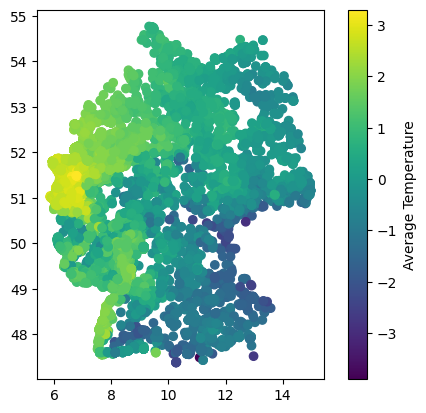

In [19]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_calopteryx_splendens_full_avg_temp.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data.plot(column='Avg_Temperature', legend=True, legend_kwds={'label': 'Average Temperature'})

# Further experiments

In this chapter, some other useful links between Geo Engine and Python are shown.

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa
/home/duempelmann/geoengine_env/lib/python3.10/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


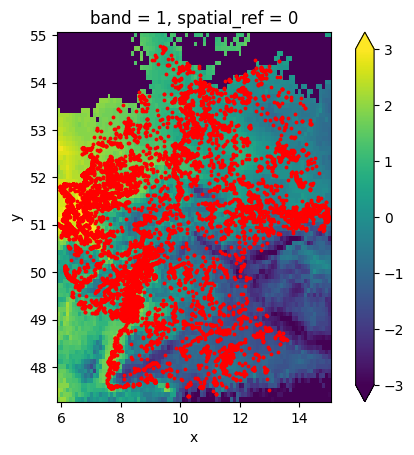

In [20]:
#Overlay plot with context
import geopandas as gpd
import matplotlib.pyplot as plt
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a xarray dataarray
data = workflow_t_avg.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmin=-3, vmax=3)
data_calopteryx_splendens.plot(ax=plt.gca(), color='red', markersize=3)
plt.show()